Epoch 1/10, Train Loss: 1.9685, Val Loss: 1.9837, Val Accuracy: 0.3002
Epoch 2/10, Train Loss: 1.8911, Val Loss: 1.9113, Val Accuracy: 0.3264
Epoch 3/10, Train Loss: 1.8420, Val Loss: 1.8622, Val Accuracy: 0.3452
Epoch 4/10, Train Loss: 1.8137, Val Loss: 1.8333, Val Accuracy: 0.3646
Epoch 5/10, Train Loss: 1.7988, Val Loss: 1.8207, Val Accuracy: 0.3554
Epoch 6/10, Train Loss: 1.7685, Val Loss: 1.7947, Val Accuracy: 0.3722
Epoch 7/10, Train Loss: 1.7495, Val Loss: 1.7756, Val Accuracy: 0.3822
Epoch 8/10, Train Loss: 1.7358, Val Loss: 1.7642, Val Accuracy: 0.3822
Epoch 9/10, Train Loss: 1.7206, Val Loss: 1.7516, Val Accuracy: 0.3906
Epoch 10/10, Train Loss: 1.7047, Val Loss: 1.7341, Val Accuracy: 0.3942
Hidden Size: 128, LR: 0.001, Lambda: 0.0, Accuracy: 0.3942
Epoch 1/10, Train Loss: 1.9845, Val Loss: 1.9958, Val Accuracy: 0.2960
Epoch 2/10, Train Loss: 1.8931, Val Loss: 1.9063, Val Accuracy: 0.3284
Epoch 3/10, Train Loss: 1.8440, Val Loss: 1.8580, Val Accuracy: 0.3510
Epoch 4/10, Train

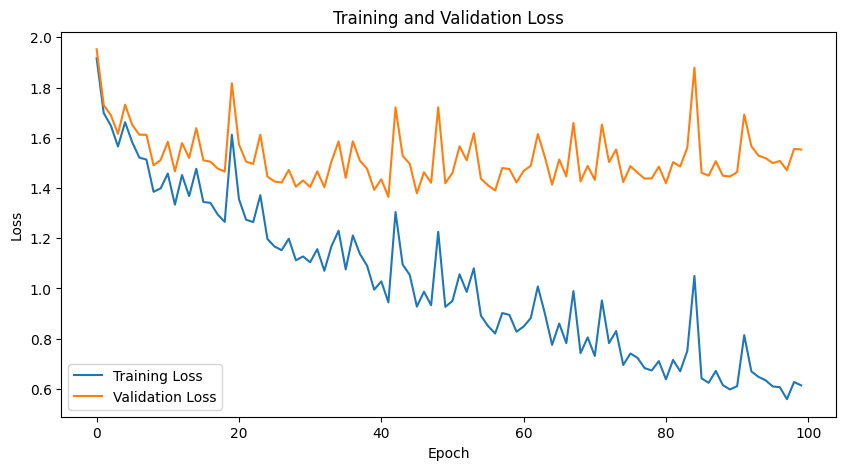

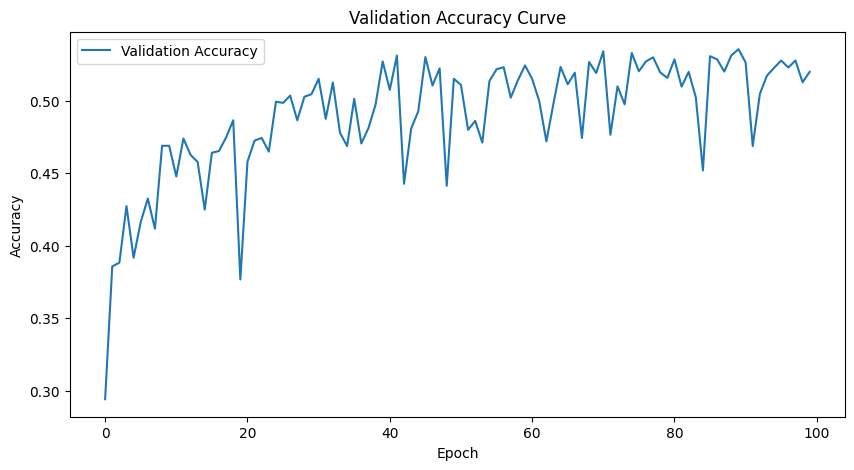

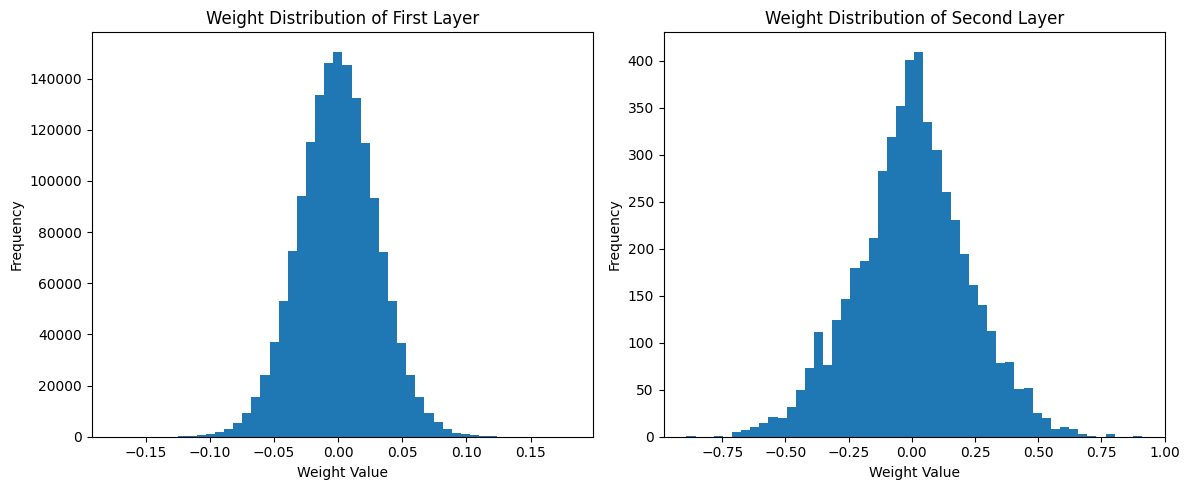

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# 数据加载和预处理
def load_data():
    # 加载 CIFAR-10 数据集
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # 归一化
    X_train = X_train.reshape(-1, 32*32*3) / 255.0
    X_test = X_test.reshape(-1, 32*32*3) / 255.0
    
    # One-Hot 编码
    y_train = np.eye(10)[y_train.reshape(-1)]
    y_test = np.eye(10)[y_test.reshape(-1)]
    
    # 划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# 三层神经网络
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        
        # 初始化权重和偏置
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2.0 / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2.0 / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))
    
    def activation_func(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            return np.tanh(x)
    
    def activation_grad(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            return x * (1 - x)
        else:
            return 1 - x ** 2
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation_func(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.y_hat = self.softmax(self.z2)
        return self.y_hat
    
    def compute_loss(self, y, y_hat, lambd=0.0):
        m = y.shape[0]
        cross_entropy = -np.sum(y * np.log(y_hat + 1e-8)) / m
        L2_regularization = (lambd / (2 * m)) * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        return cross_entropy + L2_regularization
    
    def backward(self, X, y, y_hat, lambd=0.0):
        m = y.shape[0]
        
        # 输出层梯度
        dz2 = y_hat - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2) + (lambd/m) * self.W2
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        # 隐藏层梯度
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.activation_grad(self.a1)
        dW1 = (1/m) * np.dot(X.T, dz1) + (lambd/m) * self.W1
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def update_weights(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

# 训练函数
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, learning_rate=0.01, lambd=0.0, lr_decay=0.99):
    train_losses = []
    val_losses = []
    val_accuracies = []  # 用于存储验证集准确率
    best_val_loss = float('inf')
    best_weights = None
    
    for epoch in range(epochs):
        # 打乱数据
        permutation = np.random.permutation(X_train.shape[0])
        X_train = X_train[permutation]
        y_train = y_train[permutation]
        
        # 分批训练
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            y_hat = model.forward(X_batch)
            loss = model.compute_loss(y_batch, y_hat, lambd)
            dW1, db1, dW2, db2 = model.backward(X_batch, y_batch, y_hat, lambd)
            model.update_weights(dW1, db1, dW2, db2, learning_rate)
        
        # 学习率衰减
        learning_rate *= lr_decay
        
        # 计算训练集和验证集的损失
        y_train_hat = model.forward(X_train)
        train_loss = model.compute_loss(y_train, y_train_hat, lambd)
        train_losses.append(train_loss)
        
        y_val_hat = model.forward(X_val)
        val_loss = model.compute_loss(y_val, y_val_hat, lambd)
        val_losses.append(val_loss)
        
        # 计算验证集准确率
        val_accuracy = np.mean(np.argmax(y_val_hat, axis=1) == np.argmax(y_val, axis=1))
        val_accuracies.append(val_accuracy)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = {'W1': model.W1, 'b1': model.b1, 'W2': model.W2, 'b2': model.b2}
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # 加载最佳权重
    model.W1 = best_weights['W1']
    model.b1 = best_weights['b1']
    model.W2 = best_weights['W2']
    model.b2 = best_weights['b2']
    
    return train_losses, val_losses, val_accuracies

# 测试函数
def test_model(model, X_test, y_test):
    y_test_hat = model.forward(X_test)
    test_accuracy = np.mean(np.argmax(y_test_hat, axis=1) == np.argmax(y_test, axis=1))
    return test_accuracy

# 参数查找
def hyperparameter_search():
    input_size = 32*32*3
    output_size = 10
    hidden_sizes = [128, 256, 512]
    learning_rates = [0.001, 0.01, 0.1]
    lambdas = [0.0, 0.001, 0.01]
    
    best_accuracy = 0.0
    best_params = {}
    
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for lambd in lambdas:
                model = NeuralNetwork(input_size, hidden_size, output_size, activation='relu')
                train_losses, val_losses, val_accuracies = train_model(model, X_train, y_train, X_val, y_val, 
                                                                       epochs=10, batch_size=32, 
                                                                       learning_rate=lr, lambd=lambd)
                accuracy = val_accuracies[-1]
                print(f"Hidden Size: {hidden_size}, LR: {lr}, Lambda: {lambd}, Accuracy: {accuracy:.4f}")
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'hidden_size': hidden_size, 'lr': lr, 'lambd': lambd}
    
    return best_params

# 可视化损失曲线
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()

# 可视化准确率曲线
def plot_accuracy_curve(val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()
    plt.savefig('accuracy_curve.png')
    plt.show()

# 可视化模型参数
def visualize_weights(model):
    W1 = model.W1
    W2 = model.W2
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(W1.flatten(), bins=50)
    plt.title('Weight Distribution of First Layer')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(W2.flatten(), bins=50)
    plt.title('Weight Distribution of Second Layer')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('weight_distribution.png')
    plt.show()

# 主程序
if __name__ == "__main__":
    # 加载数据
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()
    
    # 参数查找
    best_params = hyperparameter_search()
    print(f"Best Parameters: {best_params}")
    
    # 使用最佳参数训练最终模型
    model = NeuralNetwork(input_size=32*32*3, 
                          hidden_size=best_params['hidden_size'], 
                          output_size=10, 
                          activation='relu')
    train_losses, val_losses, val_accuracies = train_model(model, X_train, y_train, X_val, y_val, 
                                                           epochs=100, batch_size=32, 
                                                           learning_rate=best_params['lr'], 
                                                           lambd=best_params['lambd'])
    
    # 测试
    test_accuracy = test_model(model, X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # 保存模型权重
    np.savez('model_weights.npz', W1=model.W1, b1=model.b1, W2=model.W2, b2=model.b2)
    print("Model weights saved to model_weights.npz")
    
    # 可视化
    plot_loss_curve(train_losses, val_losses)
    plot_accuracy_curve(val_accuracies)
    visualize_weights(model)